## Imports and Initial Configuration
The necessary Qiskit modules are imported for simulation and execution on real hardware.

In [1]:
from qiskit import QuantumCircuit
import numpy as np
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, Estimator, EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeMarrakesh, FakeBrisbane
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

# 1. Create GHZ circuit

In [2]:
#Method that creates a linear GHZ circuit
def create_lineal_ghz_circuit(num_qubits):
    # Apply CNOT gates between the first qubit and all other qubits
    ghz_circuit = QuantumCircuit(num_qubits)

    # Apply a Hadamard gate to the first qubit
    ghz_circuit.h(0)

    # Apply CNOT gates to create the GHZ state
    for i in range(num_qubits -1):
        ghz_circuit.cx(i, i+1)

    return ghz_circuit

#Method that creates a alternative linear GHZ circuit
def create_lineal_ghz_circuit_2(num_qubits):
    ghz_circuit = QuantumCircuit(num_qubits)

    # Apply a Hadamard gate to the middle qubit
    ghz_circuit.h((num_qubits // 2)-1)

    # Apply CNOT gates to create the GHZ state
    for i in range(0, (num_qubits // 2)-1):
        ghz_circuit.cx(num_qubits // 2 + i -1, num_qubits // 2 + i )
        ghz_circuit.cx(num_qubits // 2 - i -1, num_qubits // 2 - i - 2)

    if num_qubits % 2 == 0:
        ghz_circuit.cx(num_qubits-2, num_qubits-1)

    return ghz_circuit

#Method that creates a exponential GHZ circuit
def create_exponential_ghz_circuit(num_qubits):
    ghz_circuit = QuantumCircuit(num_qubits)

    # Apply a Hadamard gate to the first qubit
    ghz_circuit.h(0)

    superposition_qubits = [0]
    non_superposition_qubits = list(range(1, num_qubits))

    while non_superposition_qubits:
        new_superposition_qubits = []
        for qubit in superposition_qubits:
            if not non_superposition_qubits:
                break
            qubit_to_superpose = non_superposition_qubits.pop(0)
            ghz_circuit.cx(qubit, qubit_to_superpose)
            new_superposition_qubits.append(qubit_to_superpose)
        superposition_qubits.extend(new_superposition_qubits)

    return ghz_circuit

#Method that creates a exponential alternative GHZ circuit
def create_exponential_ghz_circuit_2(num_qubits):
    ghz_circuit = QuantumCircuit(num_qubits)
    # Apply a Hadamard gate to the first qubit
    ghz_circuit.h(0)

    l = int(np.ceil(np.log2(num_qubits)))
    for i in range(l, 0, -1):
        for j in range(0, num_qubits, 2**i):
            if j + 2**(i-1) < num_qubits:
                ghz_circuit.cx(j, j + 2**(i-1)) 
    return ghz_circuit


def create_ghz_circuit(num_qubits, mode="lineal"):
    """
    Create a GHZ (Greenberger-Horne-Zeilinger) state circuit for the specified number of qubits.

    Args:
        num_qubits (int): The number of qubits in the GHZ state.

    Returns:
        QuantumCircuit: A quantum circuit that prepares the GHZ state.
    """
    if num_qubits < 2:
        raise ValueError("GHZ state requires at least 2 qubits.")

    if mode == "lineal":
        ghz_circuit = create_lineal_ghz_circuit(num_qubits)
    elif mode == "lineal_v2":
        ghz_circuit = create_lineal_ghz_circuit_2(num_qubits)
    elif mode == "log":
        ghz_circuit = create_exponential_ghz_circuit(num_qubits)
    elif mode == "log_v2":
        ghz_circuit = create_exponential_ghz_circuit_2(num_qubits)
    else:
        raise ValueError("Invalid mode. Choose 'lineal', 'lineal_v2', 'log', or 'log_v2'.")
    

    return ghz_circuit

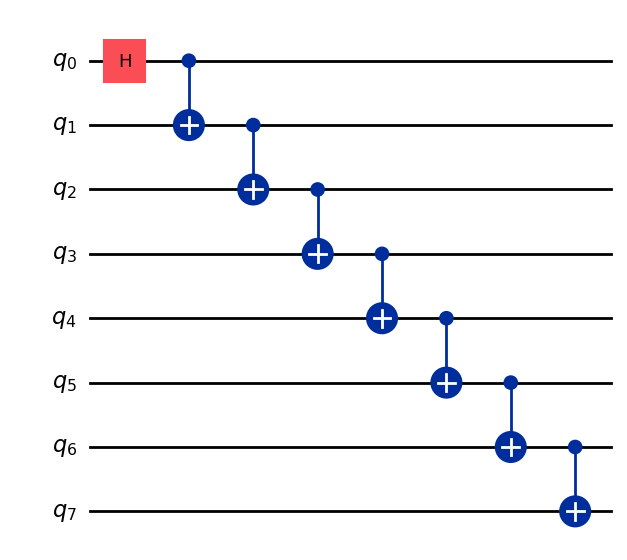

In [ ]:
#Create an 8-qubit GHz circuit with linear mode connection
create_ghz_circuit(8, mode="lineal").draw("mpl") 

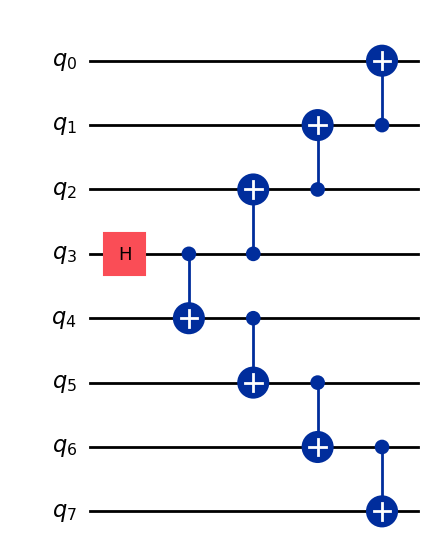

In [ ]:
#Create an 8-qubit GHz circuit with a linear variant
create_ghz_circuit(8, mode="lineal_v2").draw("mpl")

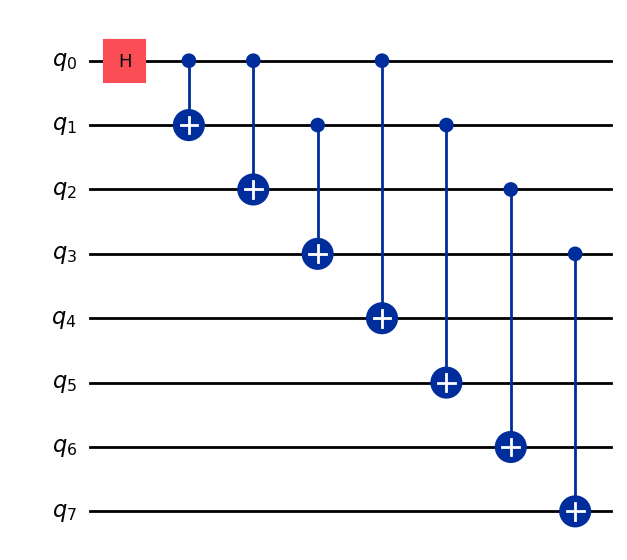

In [ ]:
#Create an 8-qubit GHz circuit using a logarithmic (log) structure
create_ghz_circuit(8, mode="log").draw("mpl")

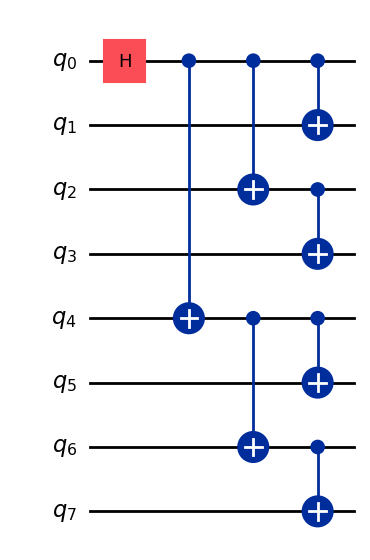

In [ ]:
#Create an 8-qubit GHz circuit using an optimized logarithmic variant (log_v2)
create_ghz_circuit(8, mode="log_v2").draw("mpl")

# 2. Compute the direct 
A direct estimate of the fidelity of a quantum state is calculated using samples from its stabilizer pool. This technique is useful for verifying how close a prepared quantum state is to an expected ideal state.

In [3]:
def compute_l(epsilon, delta):
    '''
    l = 8 * log(4 / delta) / epsilon^2
    '''
    return 8 * np.log(4 / delta) / epsilon**2

def compute_m_i(epsilon, delta):
    '''
    m_i <= 1 + 8 * log(4 / delta) / (l * epsilon^2)
    '''
    l = compute_l(epsilon, delta)
    return 1 + 8 * np.log(4 / delta) / (l * epsilon**2)

def pauli_product(p1, p2):
    """
    Multiply two Pauli operators (I, X, Y, Z) and return:
    - the result (I, X, Y, Z)
    - the phase (±1, ±i), but we ignore imaginary phase for DFE
    """
    # Pauli multiplication table: result and sign
    table = {
        ('I', 'I'): ('I', 1), ('I', 'X'): ('X', 1), ('I', 'Y'): ('Y', 1), ('I', 'Z'): ('Z', 1),
        ('X', 'I'): ('X', 1), ('X', 'X'): ('I', 1), ('X', 'Y'): ('Z', 1j), ('X', 'Z'): ('Y', -1j),
        ('Y', 'I'): ('Y', 1), ('Y', 'X'): ('Z', -1j), ('Y', 'Y'): ('I', 1), ('Y', 'Z'): ('X', 1j),
        ('Z', 'I'): ('Z', 1), ('Z', 'X'): ('Y', 1j), ('Z', 'Y'): ('X', -1j), ('Z', 'Z'): ('I', 1),
    }
    result, phase = table[(p1, p2)]
    return result, phase

def multiply_pauli_strings(s1, s2):
    """
    Multiply two full Pauli strings and return:
    - the resulting string
    - the overall sign (±1) ignoring imaginary components
    """
    result = []
    phase = 1
    for p1, p2 in zip(s1, s2):
        r, ph = pauli_product(p1, p2)
        result.append(r)
        phase *= ph
    sign = 1 if phase.real > 0 else -1  # Only track ±1
    return ''.join(result), sign

def ghz_stabilizer_generators(n):
    """
    Return the GHZ_n stabilizer generators.
    - One global X generator: X⊗X⊗...⊗X
    - n-1 Z pair generators: Z_i Z_{i+1}
    """
    generators = []

    # X⊗X⊗...⊗X
    generators.append('X' * n)

    # Z_i Z_{i+1}
    for i in range(n - 1):
        g = ['I'] * n
        g[i] = 'Z'
        g[i + 1] = 'Z'
        generators.append(''.join(g))

    return generators

def generate_ghz_stabilizer_group(n):
    """
    Return a dictionary {pauli_str: sign} for the GHZ stabilizer group.
    """
    generators = ghz_stabilizer_generators(n)
    num_gens = len(generators)

    group = {}
    for binary in itertools.product([0, 1], repeat=num_gens):
        if sum(binary) == 0:
            continue  # skip identity
        current = 'I' * n
        sign = 1
        for i, b in enumerate(binary):
            if b:
                current, s = multiply_pauli_strings(current, generators[i])
                sign *= s
        group[current] = sign

    return group


# 3. Adapt to QPU functionality
In this phase, a quantum circuit is transpiled so that it is compatible and efficient with a specific quantum backend, such as a real or simulated quantum processor.

In [4]:
"""
Transpiles a quantum circuit to make it compatible with a specific quantum backend.

Parameters:
circuit: Original quantum circuit (QuantumCircuit).
backend: Target backend (e.g., FakeMarrakesh, FakeBrisbane, or a real QPU).
optimization_level: Optimization level (0 to 3) — the higher the value, the more optimizations applied.

Returns:
transpiled_circuit: Optimized and compatible version of the circuit for that backend.
"""
def transpile_circuit(circuit, backend, optimization_level=3):
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    transpiled_circuit = pass_manager.run(circuit)
    return transpiled_circuit

In [ ]:
# Dictionaries for storing the depth and number of operations of GHz circuits
# for different construction modes ('linear', 'linear_v2', 'log', 'log_v2')
# both before and after transpiling for different simulated backends.
initial_depth = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}
transpiled_depth_1 = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}
transpiled_depth_2 = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}

initial_ops = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}
transpiled_ops_1 = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}
transpiled_ops_2 = {"lineal": [], "lineal_v2": [], "log": [], "log_v2": []}


# Maximum number of qubits to evaluate (from 2 to num_qubits - 1)
num_qubits = 125

# Iterate over each GHZ circuit construction mode
for circuit_conf in tqdm(["lineal", "lineal_v2", "log", "log_v2"], desc="mode", unit="items"):
    for i in tqdm(range(2, num_qubits), desc="Inner Loop", unit="qubit setup", leave=False):
        circuit = create_ghz_circuit(i, mode=circuit_conf)
        initial_depth[circuit_conf].append(circuit.depth())
        initial_ops[circuit_conf].append(sum(circuit.count_ops().values()))

        transpiled_circuit_1 = transpile_circuit(circuit, backend=AerSimulator().from_backend(FakeMarrakesh()))
        transpiled_circuit_2 = transpile_circuit(circuit, backend=AerSimulator().from_backend(FakeBrisbane()))

        transpiled_depth_1[circuit_conf].append(transpiled_circuit_1.depth())
        transpiled_depth_2[circuit_conf].append(transpiled_circuit_2.depth())
        transpiled_ops_1[circuit_conf].append(transpiled_circuit_1.count_ops().get("cz", 0))
        transpiled_ops_2[circuit_conf].append(transpiled_circuit_2.count_ops().get("ecr", 0))

mode:   0%|          | 0/4 [00:00<?, ?items/s]

Inner Loop:   0%|          | 0/123 [00:00<?, ?qubit setup/s]

Inner Loop:   0%|          | 0/123 [00:00<?, ?qubit setup/s]

Inner Loop:   0%|          | 0/123 [00:00<?, ?qubit setup/s]

Inner Loop:   0%|          | 0/123 [00:00<?, ?qubit setup/s]

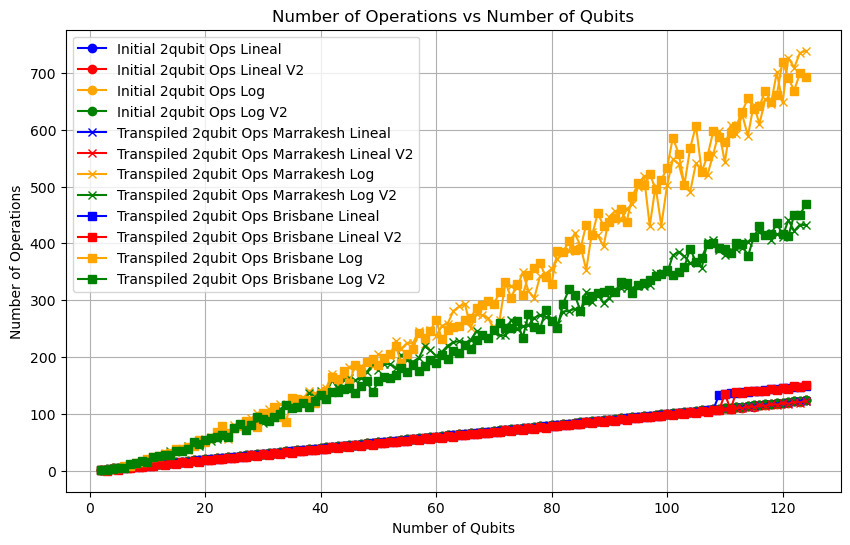

In [ ]:
# Plot the number of 2-qubit operations (as CX) in GHz circuits
# built with different modes (linear, logarithmic, etc.), before and after
# transpiling for different simulated quantum backends (Marrakesh and Brisbane).
plt.figure(figsize=(10, 6))

# Initial operations before transpiling
plt.plot(range(2, num_qubits), initial_ops["lineal"], label='Initial 2qubit Ops Lineal', marker='o', color='blue')
plt.plot(range(2, num_qubits), initial_ops["lineal_v2"], label='Initial 2qubit Ops Lineal V2', marker='o', color='red')
plt.plot(range(2, num_qubits), initial_ops["log"], label='Initial 2qubit Ops Log', marker='o', color='orange')
plt.plot(range(2, num_qubits), initial_ops["log_v2"], label='Initial 2qubit Ops Log V2', marker='o', color='green')

# Operations after transpiling for Marrakesh backend
plt.plot(range(2, num_qubits), transpiled_ops_1["lineal"], label='Transpiled 2qubit Ops Marrakesh Lineal', marker='x', color='blue')
plt.plot(range(2, num_qubits), transpiled_ops_1["lineal_v2"], label='Transpiled 2qubit Ops Marrakesh Lineal V2', marker='x', color='red')
plt.plot(range(2, num_qubits), transpiled_ops_1["log"], label='Transpiled 2qubit Ops Marrakesh Log', marker='x', color='orange')
plt.plot(range(2, num_qubits), transpiled_ops_1["log_v2"], label='Transpiled 2qubit Ops Marrakesh Log V2', marker='x', color='green')

# Operations after transpiling for Brisbane backend
plt.plot(range(2, num_qubits), transpiled_ops_2["lineal"], label='Transpiled 2qubit Ops Brisbane Lineal', marker='s', color='blue')
plt.plot(range(2, num_qubits), transpiled_ops_2["lineal_v2"], label='Transpiled 2qubit Ops Brisbane Lineal V2', marker='s', color='red')
plt.plot(range(2, num_qubits), transpiled_ops_2["log"], label='Transpiled 2qubit Ops Brisbane Log', marker='s', color='orange')
plt.plot(range(2, num_qubits), transpiled_ops_2["log_v2"], label='Transpiled 2qubit Ops Brisbane Log V2', marker='s', color='green')

# Setting up axes and legend
plt.xlabel('Number of Qubits')
plt.ylabel('Number of Operations')
plt.title('Number of Operations vs Number of Qubits')
plt.legend()
plt.grid()
plt.show()

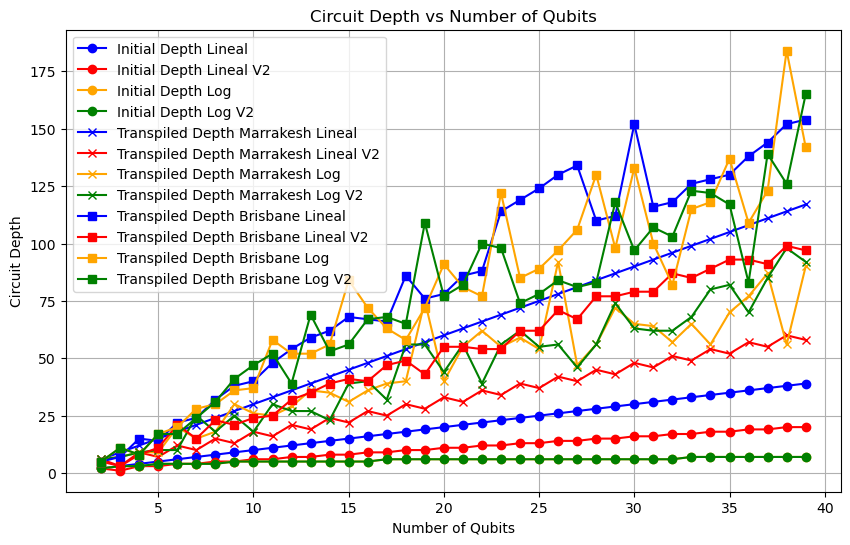

In [ ]:
# Plot the depth of GHz circuits for different construction modes,
# before and after transpiling for simulated backends in Marrakech and Brisbane,
# as a function of the number of qubits.
plt.figure(figsize=(10, 6))

# Initial depth (before transpiling)
plt.plot(range(2, num_qubits), initial_depth["lineal"], label='Initial Depth Lineal', marker='o', color='blue')
plt.plot(range(2, num_qubits), initial_depth["lineal_v2"], label='Initial Depth Lineal V2', marker='o', color='red')
plt.plot(range(2, num_qubits), initial_depth["log"], label='Initial Depth Log', marker='o', color='orange')
plt.plot(range(2, num_qubits), initial_depth["log_v2"], label='Initial Depth Log V2', marker='o', color='green')

# Profundidad después de transpilar para Marrakesh
plt.plot(range(2, num_qubits), transpiled_depth_1["lineal"], label='Transpiled Depth Marrakesh Lineal', marker='x', color='blue')
plt.plot(range(2, num_qubits), transpiled_depth_1["lineal_v2"], label='Transpiled Depth Marrakesh Lineal V2', marker='x', color='red')
plt.plot(range(2, num_qubits), transpiled_depth_1["log"], label='Transpiled Depth Marrakesh Log', marker='x', color='orange')
plt.plot(range(2, num_qubits), transpiled_depth_1["log_v2"], label='Transpiled Depth Marrakesh Log V2', marker='x', color='green')

# Profundidad después de transpilar para Brisbane
plt.plot(range(2, num_qubits), transpiled_depth_2["lineal"], label='Transpiled Depth Brisbane Lineal', marker='s', color='blue')
plt.plot(range(2, num_qubits), transpiled_depth_2["lineal_v2"], label='Transpiled Depth Brisbane Lineal V2', marker='s', color='red')
plt.plot(range(2, num_qubits), transpiled_depth_2["log"], label='Transpiled Depth Brisbane Log', marker='s', color='orange')
plt.plot(range(2, num_qubits), transpiled_depth_2["log_v2"], label='Transpiled Depth Brisbane Log V2', marker='s', color='green')

#Final chart settings
plt.xlabel('Number of Qubits')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth vs Number of Qubits')
plt.legend()
plt.grid()
plt.show()

# 4. Run circuit on 
Prepare and run a quantum circuit on a quantum backend (real or simulated) using the qiskit_ibm_runtime framework, which is the modern and optimized way to run jobs on IBM QPUs.

In [5]:
def run_circuit(circuit, observables, shots, mode):

    estimator = Estimator(mode=mode, options=EstimatorOptions(default_shots=shots))

    job = estimator.run([(circuit, obs) for obs in observables])

    result = job.result()
    
    return result

In [6]:
def select_stabilizer_observables(n, num_observables):
    stabilizers = generate_ghz_stabilizer_group(n)
    observables = list(stabilizers.keys())
    selected_obs = random.choices(observables, k=num_observables)
    selected_signs = [stabilizers[obs] for obs in selected_obs]
    return [SparsePauliOp.from_list([(p, 1.0)]) for p in selected_obs], np.array(selected_signs)


In [7]:
num_qubits = 6
epsilon = 0.05
delta = 0.05

l = compute_l(epsilon, delta)
print(f"Num observables: {l}")
l = int(np.ceil(l))
m_i = compute_m_i(epsilon, delta)
print(f"Num shots: {m_i}")

circuit = create_ghz_circuit(num_qubits)
observables, signs = select_stabilizer_observables(num_qubits, l)
simul = AerSimulator()
estimator = Estimator(mode=simul, options=EstimatorOptions(default_shots=m_i))
r = estimator.run([(circuit, obs) for obs in observables]).result()
r_ = np.array([pub_result.data.evs for pub_result in r])
fidelity = np.mean(r_ * signs)
print(f"Estimated fidelity: {fidelity}")


Num observables: 14022.485230956418
Num shots: 2.0
Estimated fidelity: 1.0


In [8]:
"""
This block of code estimates the fidelity of a 7-qubit GHz quantum circuit running in a simulator,
using statistical techniques to do so efficiently.
"""
num_qubits = 7
epsilon = 0.05
delta = 0.05
l = compute_l(epsilon, delta)
print(f"Num observables: {l}")
l = int(np.ceil(l))
m_i = compute_m_i(epsilon, delta)
print(f"Num shots: {m_i}")

circuit = create_ghz_circuit(num_qubits)
observables, signs = select_stabilizer_observables(num_qubits, l)

simul = AerSimulator().from_backend(FakeBrisbane())
transpiled_circuit = transpile_circuit(circuit, simul)
observable_isa = [observable.apply_layout(layout=transpiled_circuit.layout) for observable in observables]

estimator = Estimator(mode=simul, options=EstimatorOptions(default_shots=m_i))
r = estimator.run([(transpiled_circuit, obs) for obs in observable_isa]).result()
r_ = np.array([pub_result.data.evs for pub_result in r])
fidelity = np.mean(r_ * signs)
print(f"Estimated fidelity: {fidelity}")

Num observables: 14022.485230956418
Num shots: 2.0
Estimated fidelity: 0.7864936176281823


In [ ]:
"""
This code performs fidelity estimations for GHz states of different
sizes (from 2 to 8 qubits) in three simulators mimicking real-world
devices (FakeTorino, FakeMarrakesh, and FakeBrisbane). It also checks whether the estimated fidelity
meets a defined minimum threshold (threshold = 0.7), and if not, stops the evaluation for that backend.
"""
epsilon = 0.05
delta = 0.05
threshold = 0.7

l = compute_l(epsilon, delta)
print(f"Num observables: {l}")
l = int(np.ceil(l))
m_i = compute_m_i(epsilon, delta)
print(f"Num shots: {m_i}")

num_qubits = 8

torino_data = FakeTorino()
torino_backend = AerSimulator().from_backend(torino_data)

marrakes_data = FakeMarrakesh()
marrakes_backend = AerSimulator().from_backend(marrakes_data)

brisbane_data = FakeBrisbane()
brisbane_backend = AerSimulator().from_backend(brisbane_data)

backends = [torino_backend, marrakes_backend, brisbane_backend]

for backend in backends:
    # fake backend for demonstration purposes
    with Session(backend=backend) as session:
        for n_qubits in range(2, num_qubits + 1):
            print(f"Running GHZ circuit with {n_qubits} qubits on backend {backend}")

            ghz_circuit = create_ghz_circuit(num_qubits)
            transpiled_circuit = transpile_circuit(ghz_circuit, backend)
            
            # Select random observables
            observables, signs = select_stabilizer_observables(num_qubits, l)
            observable_isa = [observable.apply_layout(layout=transpiled_circuit.layout) for observable in observables]
            
            # Run the circuit for each observable
            result = run_circuit(transpiled_circuit, observable_isa, shots=m_i, mode=session)
            expected_vals = np.array([pub_result.data.evs for pub_result in result])
            fidelity_estimate = np.mean(expected_vals * signs)
            print(f"Results for {n_qubits} qubits on backend {session.backend()}: {fidelity_estimate:.4f}")
            print("--------------------------------------------------")
            if fidelity_estimate < threshold:
                print(f"Fidelity estimate {fidelity_estimate:.4f} is below the threshold {threshold:.4f}.")
                print(f"Max number of qubits meeting the specified fidelity {n_qubits}.")
                break
        print(f"Finished running GHZ circuits on backend {session.backend()}.")
        print(f"Specified fidelity met for {num_qubits}.")
        print("--------------------------------------------------")


Num observables: 14022.485230956418
Num shots: 2.0
Running GHZ circuit with 2 qubits on backend AerSimulator('aer_simulator_from(fake_torino)'
             noise_model=<NoiseModel on ['cz', 'id', 'sx', 'reset', 'x', 'measure']>)


c:\Users\sergio.h\AppData\Local\anaconda3\envs\hencoding\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction QId_d0 on channel d0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\sergio.h\AppData\Local\anaconda3\envs\hencoding\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction QId_d1 on channel d1 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\sergio.h\AppData\Local\anaconda3\envs\hencoding\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction QId_d2 on channel d2 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\sergio.h\AppData\Local\anaconda3\envs\hencodin

Results for 2 qubits on backend aer_simulator_from(fake_torino): 0.7140
--------------------------------------------------
Running GHZ circuit with 3 qubits on backend AerSimulator('aer_simulator_from(fake_torino)'
             noise_model=<NoiseModel on ['cz', 'id', 'sx', 'reset', 'x', 'measure']>)
Results for 3 qubits on backend aer_simulator_from(fake_torino): 0.7001
--------------------------------------------------
Running GHZ circuit with 4 qubits on backend AerSimulator('aer_simulator_from(fake_torino)'
             noise_model=<NoiseModel on ['cz', 'id', 'sx', 'reset', 'x', 'measure']>)
Results for 4 qubits on backend aer_simulator_from(fake_torino): 0.6217
--------------------------------------------------
Fidelity estimate 0.6217 is below the threshold 0.7000.
Max number of qubits meeting the specified fidelity {n_qubits}.
Finished running GHZ circuits on backend aer_simulator_from(fake_torino).
Specified fidelity met for {num_qubits}.
----------------------------------------

In [7]:
from utils.benchmark import run_GHZ_experiment
from utils.circuits import create_ghz_circuit
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator

def transpile_circuit(circuit, backend, optimization_level=3):
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    transpiled_circuit = pass_manager.run(circuit)
    return transpiled_circuit

num_qubits = 3  # Example number of qubits
ghz_circuit = create_ghz_circuit(num_qubits, mode="lineal_v2")

transpiled_circuit = transpile_circuit(ghz_circuit, backend=FakeTorino())


_, _, fidelity = run_GHZ_experiment(
                    num_qubits=num_qubits,
                    mode=AerSimulator(),
                    transpiled_circuit=ghz_circuit,
                    epsilon=0.05,
                    delta=0.05
                )
print(f"Fidelity estimate for {num_qubits} qubits: {fidelity:.4f}")

Fidelity estimate for 3 qubits: 0.2566
